#### Author:
Simon Hackl, 04.03.2021

Integrative Transcriptomics (IBMI), University Tübingen

#### Project:
Elaboration of a best practice for hybrid and long read de novo assembly of bacterial genomes utilizing Illumina and Oxford Nanopore Technologies reads

---

With this notebook the results of the `S3_readQualityControl.sh` and `S4_readSubsampling.sh` scripts, concerned with the quality control of used read sets, are analyzed. In order to re-run this notebook please ensure that all result files were generated and stored in the directories as it is described in the respective scripts.

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

import zipfile
import os

from itertools import chain
from matplotlib.ticker import StrMethodFormatter

In [2]:
"""
The following code is based on https://jwalton.info/Embed-Publication-Matplotlib-Latex/ 
and is used to format generated plots in LaTeX style.
"""

plt.style.use('default')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update( tex_fonts )

def set_size( width, height = False, fraction = 1, subplots = ( 1, 1 ) ) :
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    height: bool or float
            The height in points or, if False, the golden ratio is used to calculate the height.
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = ( 5**.5 - 1 ) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    if height :
        fig_height_in = height * fraction * inches_per_pt
    else :
        fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

---

#### Computing/extracting quality and coverage statistics:

The following methods are used to extract quality and coverage features from the `.cov` files generated by mapping reads with `minimap2` and analysis with `samtools depth` as well as the `.zip` reports generated by running `FastQC`.

From the extracted features a summary table will be generated that contains information about:
- the mean per read sequence quality (Phred score) extracted from the `FastQC` reports (only for non sub-samples).
- the mean depth of coverage regarding the reference genome.
- the percentage of reference genome positions with zero coverage depth.
- the expected breadth of coverage, according to the Lander-Waterman model, defined as $1 - exp( -C )$ for a given coverage $C$.

In [3]:
def coverageStatistics( sampleIdentifier, covFileIdentifier ) :
    ''' From the input parameters a .cov file is accessed from which the mean coverage depth
    and the percentage of the reference genome with zero coverage depth is reported.
    
    Parameters
    ----------
    sampleIdentifier: str
        Identifier for the reference set, one of CFT073, MGH78578, RN4220
    covFileIdentifier: str
        Identifier for the specific read set, equals the name of the .cov file generated
        by `samtools depth` with script S3 and S4, e.g. 'SRR8482567_1_2' for the MGH78578 short reads.
    Returns
    -------
    meanCoverageDepth: float
        The mean depth of coverage of the accessed file.
    coverageBreadth : float
        The percentage of positions with at least coverage 1 of the accessed file.
    '''
    
    # Parse .cov file into dictionary, each segment (plasmid, part of genome) identifier 
    # is used as a key pointing to a list of per position coverages along that segment.
    with open( './results/coverage/' + sampleIdentifier + '/' + covFileIdentifier + '.cov' ) as cf :
        line = cf.readline( )
        perPositionCoverage = { }
        while line:
            chrom, index, cov = line.strip( ).split( '\t' )
            if chrom in perPositionCoverage :
                perPositionCoverage[ chrom ].append( int( cov ) )
            else :
                perPositionCoverage[chrom ] = [ int( cov ) ]
            line = cf.readline()
            
    # Iterate over each position and sum up the depth of coverage and number of positions.
    # Thereby, positions with zero coverage are recorded.
    coverageSum = 0
    positionsNoCoverage = 0
    positionsSum = 0
    for chrom, coverages in perPositionCoverage.items( ) :
        coverageSum += sum( coverages )
        positionsNoCoverage += sum( [ coverage == 0 for coverage in coverages ] )
        positionsSum += len( coverages )
    
    # Compute mean coverage depth.
    meanCoverageDepth = ( coverageSum / positionsSum )
    
    # Compute percentage of positions with zero coverage.
    coverageBreadth = ( 1 - ( positionsNoCoverage / positionsSum ) ) * 100
    #coverageBreadth = positionsNoCoverage
    
    return meanCoverageDepth, coverageBreadth

In [4]:
def qualityStatistics( sampleIdentifier, fastqcFileIdentifier ) :
    ''' From the input parameters a .zip file (FastQC report) is accessed from which the mean per
    read sequence Phred quality score is calculated.
    
    Parameters
    ----------
    sampleIdentifier: str
        Identifier for the reference set, one of CFT073, MGH78578, RN4220
    fastqcFileIdentifier: str
        Identifier for the specific read set, equals the name of the .zip file generated
        by FastQC with script S3, e.g. 'SRR8482567_1_fastqc' for the MGH78578 forward strand short reads.
    Returns
    -------
    meanSequenceQuality: float
        The mean per sequence quality reported in the accessed FastQC report.
    '''
    
    # Parse .zip file. The section containing the per sequence quality score
    # distribution is used to compute the mean per sequence quality.
    numberOfSequences = 0
    sumSequenceQuality = 0
    meanSequenceQuality = 0
    parse = False
    with zipfile.ZipFile( './results/fastqc/' + sampleIdentifier + '/' + fastqcFileIdentifier + '_fastqc.zip' ) as myzip:
        with myzip.open( fastqcFileIdentifier + '_fastqc/fastqc_data.txt' ) as myfile:
            lines = str( myfile.read( ).decode("utf-8")  ).split( '\n' )
            for line in lines :
                if line.startswith( 'Total Sequences' ) :
                    numberOfSequences = int( line.split( '\t' )[1] )
                elif line.startswith( '>>Per sequence quality scores' ) or parse == True :
                    parse = True
                    if line.startswith( '#Quality' ) :
                        continue
                    elif line.startswith( '>>END' ) :
                        parse = False
                        meanSequenceQuality = sumSequenceQuality / numberOfSequences
                    elif parse == True and not line.startswith( '>>' ) :
                        quality, count = line.strip( '\n' ).split( '\t' )
                        quality = int( quality )
                        count = int( float( count ) )
                        sumSequenceQuality += quality * count
    return meanSequenceQuality

In [5]:
def printReadStatistics( ) :
    ''' Calls the `coverageStatistics` and `qualityStatistics` methods for each pair of sample- and read identifiers used
    for the project. All extracted and computed features visualized in a Pandas dataframe.
    '''
    # Helper method to calculate Lander–Waterman expected breadth of coverage.
    getExpectedCoverage = lambda cov : np.round( ( 1 - np.exp( - cov ) ) * 100, 2 )
    
    # Prepare dictionary to generate dataframe.
    columns = { "read set identifier": [ "mean read quality", "mean depth of coverage", "breadth of coverage", "expected breadth of coverage" ] }
    # For each pair of sample- and read-identifiers used in the project...
    for sample, longreadID, shortreadID, hasSubsample, processShortreads in [
        ( "CFT073", "SRR8494940", "SRR8482585", True, True ),
        ( "MGH78578", "SRR8494915", "SRR8482567", False, True ),
        ( "RN4220", "QNFLR049AW~guppy3210", "QNFLR056AF", True, True ),
        ( "RN4220", "QNFLR049AW~guppy4011", "-", True, False )
    ] :
        # short read statistics are computed...
        if processShortreads :
            meanCoverageDepth, coverageBreadth = coverageStatistics( sample, shortreadID + "_1_2" )
            qual1 = qualityStatistics( sample, shortreadID + "_1" )
            qual2 = qualityStatistics( sample, shortreadID + "_2" )
            meanReadQuality = ( qual1 + qual2 ) / 2
            # ...and stored in the columns dictionary.
            columns[ shortreadID ] = [ np.round( meanReadQuality, 2 ),
                                      np.round( meanCoverageDepth, 2 ),
                                      np.round( coverageBreadth, 4 ),
                                      np.round( getExpectedCoverage( meanCoverageDepth ), 2 ) ]
        # long read statistics are computed...
        meanCoverageDepth, coverageBreadth = coverageStatistics( sample, longreadID + "-t" )
        meanReadQuality = qualityStatistics( sample, longreadID + "-t" )
        columns[ longreadID ] = [ np.round( meanReadQuality, 2 ),
                                      np.round( meanCoverageDepth, 2 ),
                                      np.round( coverageBreadth, 4 ),
                                      np.round( getExpectedCoverage( meanCoverageDepth ), 2 ) ]
        # long read sub-sample files are considered, if present,...
        if hasSubsample :
            for coverage in [ '-' + str( c ) + 'X' for c in [ 200, 150, 100, 80, 60, 40, 20, 15, 10, 8, 6, 4, 2, 1 ] ] :
                meanCoverageDepth, coverageBreadth = coverageStatistics( sample, longreadID + "-t" + coverage )
                #...and stored in the columns dictionary.
                columns[ longreadID + "-t" + coverage ] = [ "-",
                                      np.round( meanCoverageDepth, 2 ),
                                      np.round( coverageBreadth, 4 ),
                                      np.round( getExpectedCoverage( meanCoverageDepth ), 2 ) ]
        
    # Generate dataframe from columns dictionary and print it.
    df = pd.DataFrame( columns )
    df.set_index( "read set identifier", inplace = True )
    return df

Now, the `printReadStatistics` method is run to print the read coverage and quality summary table.

In [6]:
df = printReadStatistics( )
df.T.head( df.shape[ 1 ] )

read set identifier,mean read quality,mean depth of coverage,breadth of coverage,expected breadth of coverage
SRR8482585,36.93,92.68,99.9542,100.0
SRR8494940,16.44,290.32,100.0,100.0
SRR8494940-t-200X,-,187.95,100.0,100.0
SRR8494940-t-150X,-,140.93,100.0,100.0
SRR8494940-t-100X,-,93.92,99.9999,100.0
SRR8494940-t-80X,-,75.18,99.9999,100.0
SRR8494940-t-60X,-,56.33,99.9995,100.0
SRR8494940-t-40X,-,37.58,99.9993,100.0
SRR8494940-t-20X,-,18.82,99.999,100.0
SRR8494940-t-15X,-,13.54,99.9977,100.0


The table is written to a supplementary file for the repository and report:

In [7]:
df.T.to_csv( "./supplementary_files/F3_readStatistics.csv" )

To validate that the sub samples were generated properly the mean difference of expected and true depth- and breadth of coverage is computed in the following.

In [8]:
expectedDOC = [ int( value.split( "-" )[ 2 ].strip( "X" ) ) for value in df.T[ df.T.index.str.contains( "X" ) ].index.tolist( ) ]
trueDOC = df.T[ df.T.index.str.contains( "X" ) ][ "mean depth of coverage" ].tolist( )
print( "Mean difference of expected and true depth of coverage is " + str( np.mean( [ expDOC - DOC for expDOC, DOC in zip( expectedDOC, trueDOC ) ] ) ) )

Mean difference of expected and true depth of coverage is 0.17380952380952425


In [9]:
expectedBOC = df.T[ df.T.index.str.contains( "X" ) ][ "expected breadth of coverage" ].tolist( )
trueBOC = df.T[ df.T.index.str.contains( "X" ) ][ "breadth of coverage" ].tolist( )
print( "Mean difference of expected and true breadth of coverage is " + str( np.mean( [ expBOC - BOC for expBOC, BOC in zip( expectedBOC, trueBOC ) ] ) ) )

Mean difference of expected and true breadth of coverage is -0.010761904761904043


In [10]:
print( df.T[ df.T.index.str.contains( "guppy4011" ) ][ "mean depth of coverage" ].tolist( )[1:] )

[205.94, 154.22, 102.92, 82.28, 61.76, 41.19, 20.57, 15.46, 10.31, 8.25, 6.18, 4.12, 2.08, 1.06]


---

#### Visualization of depth of coverage across reference genomes in higher resolution:

In addition, visualizations for the non sub-sample read sets are generated that depict the coverage along the reference genomes.

The following methods are used to compute a coverage profile for a .cov file and a reference genome. The per position depth of coverage information of the accessed .cov file is thereby split into a set of chunks, i.e. fixed length intervals of reference genome positions and for each chunk the mean depth of coverage is plotted.

In [11]:
def getPerPositionCoverage( sampleIdentifier, covFileIdentifier, segment, resolution, append = False ) :
    ''' Accesses a .cov file and returns a dictionary storing coverage information for fixed length intervals (chunks)
    along the reference genome.
    
    Parameters
    ----------
    sampleIdentifier: str
        Identifier for the reference set, one of CFT073, MGH78578, RN4220
    covFileIdentifier: str
        Identifier for the specific read set, equals the name of the .cov file generated
        by `samtools depth` with script S3 and S4, e.g. 'SRR8482567_1_2' for the MGH78578 short reads.
    resolution: int
        Default 10000; Specifies the size of each chunk as the genome length divided by the resolution.
    excludedSegments: list
        Segment names to be excluded from plot. Default is none, i.e. an empty list.
        
    Returns
    -------
    perSegmentChunkData: dict
        Dictionary containing various coverage information (mean, min, max) per chunk and also the count and length of chunks.
    '''
    
    # First the .cov file is accessed to parse the per position coverage into a dictionary.
    # The dictionary will store a key for each genomic segment.
    with open( './results/coverage/' + sampleIdentifier + '/' + covFileIdentifier ) as cf :
        perPositionCoverage = { }
        line = cf.readline()
        while line:
            seg, index, cov = line.strip( ).split( '\t' )
            if seg in perPositionCoverage :
                perPositionCoverage[ seg ].append( int( cov ) )
            else :
                perPositionCoverage[ seg ] = [ int( cov ) ]
            line = cf.readline( )
            
    if append :
        allPositionsCoverage = [ ]
        for segment in list( perPositionCoverage.keys( ) ) :
            for positionCoverage in perPositionCoverage[ segment ] :
                allPositionsCoverage.append( positionCoverage )
        return np.array_split( allPositionsCoverage, len( allPositionsCoverage ) / resolution )
    else :
        return np.array_split( perPositionCoverage[ segment ], len( perPositionCoverage[ segment ] ) / resolution )

In [12]:
def layoutCoverage( ax, coverages, colors, xlabel, title ) :
    ''' Plots a list of chunk coverages and customizes the resulting plot.
    
    Parameters
    ----------
    ax: matplotlib.pyplot.axis
        A matplotlib axis instance, i.e. the sub plot object on which the coverages are visualized.
    coverages: list
        A 3D list containing the per position coverages split into fixed size sub lists for different .cov files
        accessed, i.e. different ead samples.
    colors: list
        A list of colors used to plot the coverages from different files in distinct colors.
    xlabel: str
        The x label set for the subplot.
    title: str
        The title set for the subplot.
    '''
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    for coverage, color in zip( coverages, colors ) :
        ax.scatter( np.arange( 0, len( coverage ) ), [ np.mean( cov ) for cov in coverage ], marker=".", s=0.6, color = color )
        ax.plot( np.arange( 0, len( coverage ) ), [ np.mean( cov ) for cov in coverage ], linewidth=0.1, color = color )
    ax.set_xlim( 0, len( coverage ) )
    ax.set_ylim( bottom = 0 )
    ax.set_yscale( "symlog" )
    ax.set_xlabel( xlabel )
    ax.set_title( title )

* Generate the coverage profile for the **CFT073** reference:

In [13]:
# Access the per chunk mean DOC of the CFT073 read sets.
CFT073chrCovLong = getPerPositionCoverage( "CFT073", "SRR8494940-t.cov", "NC_004431.1", 1000 )
CFT073chrCovShort = getPerPositionCoverage( "CFT073", "SRR8482585_1_2.cov", "NC_004431.1", 1000 )

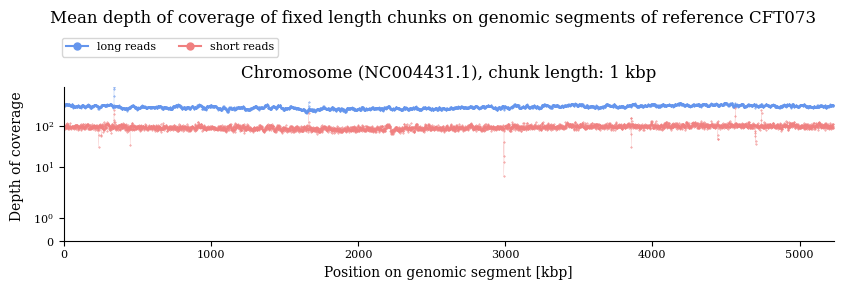

In [14]:
# Prepare the plot, i.e. as the CFT073 reference contains only one chromosome, one subplot is generated.
fig, axs = plt.subplots( nrows = 1, ncols = 1, figsize = set_size( 600, 200 ) )

layoutCoverage( axs, [ CFT073chrCovLong, CFT073chrCovShort ], [ 'cornflowerblue', 'lightcoral' ], "Position on genomic segment [kbp]", "Chromosome (NC004431.1), chunk length: 1 kbp" )

# Place labels, legend and titles for the full plot.
fig.text( -0.01, 0.5, 'Depth of coverage', va = 'center', rotation = 'vertical')
fig.suptitle( "Mean depth of coverage of fixed length chunks on genomic segments of reference CFT073", x = 0.5, y = 1.03 )
fig.legend( handles = [ Line2D( [0], [0], marker='o', color='cornflowerblue', label='long reads', markerfacecolor='cornflowerblue', markersize=5),
                        Line2D( [0], [0], marker='o', color='lightcoral', label='short reads', markerfacecolor='lightcoral', markersize=5) ],
            bbox_to_anchor=( 0.32, 0.95 ),
            ncol = 2 )

# Show the plot in tight layout.
plt.tight_layout( )

* Generate the coverage profile for the **MGH78578** reference:

In [15]:
# Access the per chunk mean DOC of the MGH78578 read sets.
MGH78578chrCovLong = getPerPositionCoverage( "MGH78578", "SRR8494915-t.cov", "NC_009648.1", 1000 )
MGH78578chrCovShort = getPerPositionCoverage( "MGH78578", "SRR8482567_1_2.cov", "NC_009648.1", 1000 )

MGH78578p1CovLong = getPerPositionCoverage( "MGH78578", "SRR8494915-t.cov", "NC_009649.1", 100 )
MGH78578p1CovShort = getPerPositionCoverage( "MGH78578", "SRR8482567_1_2.cov", "NC_009649.1", 100 )

MGH78578p2CovLong = getPerPositionCoverage( "MGH78578", "SRR8494915-t.cov", "NC_009650.1", 100 )
MGH78578p2CovShort = getPerPositionCoverage( "MGH78578", "SRR8482567_1_2.cov", "NC_009650.1", 100 )

MGH78578p3CovLong = getPerPositionCoverage( "MGH78578", "SRR8494915-t.cov", "NC_009651.1", 10 )
MGH78578p3CovShort = getPerPositionCoverage( "MGH78578", "SRR8482567_1_2.cov", "NC_009651.1", 10 )

MGH78578p4CovLong = getPerPositionCoverage( "MGH78578", "SRR8494915-t.cov", "NC_009652.1", 1 )
MGH78578p4CovShort = getPerPositionCoverage( "MGH78578", "SRR8482567_1_2.cov", "NC_009652.1", 1 )

MGH78578p5CovLong = getPerPositionCoverage( "MGH78578", "SRR8494915-t.cov", "NC_009653.1", 1 )
MGH78578p5CovShort = getPerPositionCoverage( "MGH78578", "SRR8482567_1_2.cov", "NC_009653.1", 1 )

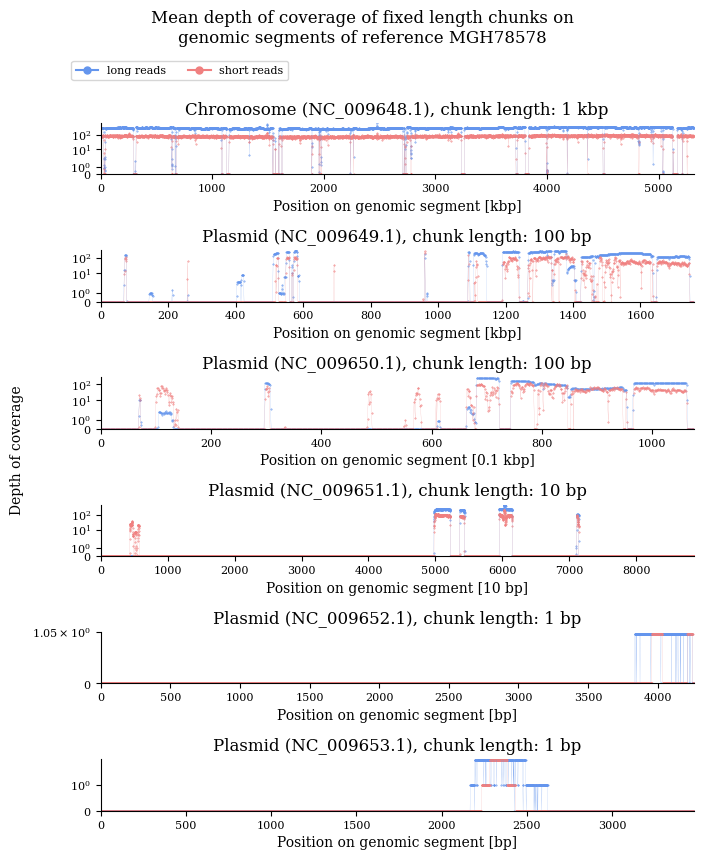

In [16]:
# Prepare the plot, i.e. as the MGH78578 reference contains one chromosome and five plasmids, six subplots are generated.
fig, axs = plt.subplots( nrows = 6, ncols = 1, figsize = set_size( 500, 600 ) )

layoutCoverage( axs[ 0 ], [ MGH78578chrCovLong, MGH78578chrCovShort ], [ 'cornflowerblue', 'lightcoral' ], "Position on genomic segment [kbp]", "Chromosome (NC_009648.1), chunk length: 1 kbp" )
layoutCoverage( axs[ 1 ], [ MGH78578p1CovLong, MGH78578p1CovShort ], [ 'cornflowerblue', 'lightcoral' ], "Position on genomic segment [kbp]", "Plasmid (NC_009649.1), chunk length: 100 bp" )
layoutCoverage( axs[ 2 ], [ MGH78578p2CovLong, MGH78578p2CovShort ], [ 'cornflowerblue', 'lightcoral' ], "Position on genomic segment [0.1 kbp]", "Plasmid (NC_009650.1), chunk length: 100 bp" )
layoutCoverage( axs[ 3 ], [ MGH78578p3CovLong, MGH78578p3CovShort ], [ 'cornflowerblue', 'lightcoral' ], "Position on genomic segment [10 bp]", "Plasmid (NC_009651.1), chunk length: 10 bp" )
layoutCoverage( axs[ 4 ], [ MGH78578p4CovLong, MGH78578p4CovShort ], [ 'cornflowerblue', 'lightcoral' ], "Position on genomic segment [bp]", "Plasmid (NC_009652.1), chunk length: 1 bp" )
layoutCoverage( axs[ 5 ], [ MGH78578p5CovLong, MGH78578p5CovShort ], [ 'cornflowerblue', 'lightcoral' ], "Position on genomic segment [bp]", "Plasmid (NC_009653.1), chunk length: 1 bp" )

# Place labels, legend and titles for the full plot.
fig.text( -0.01, 0.5, 'Depth of coverage', va = 'center', rotation = 'vertical')
fig.suptitle( "Mean depth of coverage of fixed length chunks on\ngenomic segments of reference MGH78578", x = 0.5, y = 1.03 )
fig.legend( handles = [ Line2D( [0], [0], marker='o', color='cornflowerblue', label='long reads', markerfacecolor='cornflowerblue', markersize=5),
                        Line2D( [0], [0], marker='o', color='lightcoral', label='short reads', markerfacecolor='lightcoral', markersize=5) ],
            bbox_to_anchor=( 0.4, 0.975 ),
            ncol = 2 )

# Show the plot in tight layout.
plt.tight_layout( )

* Generate the coverage profile for the **RN4220** reference:

In [17]:
# Access the per chunk mean DOC of the RN4220 read sets.
# Note: As the reference is highly fragmented all positions are treated as they would originate from one chromosome.
RN4220chrCovLongGuppy4011 = getPerPositionCoverage( "RN4220", "QNFLR049AW~guppy4011-t.cov", "", 1000, append = True )
RN4220chrCovLongGuppy3210 = getPerPositionCoverage( "RN4220", "QNFLR049AW~guppy3210-t.cov", "", 1000, append = True )
RN4220chrCovShort = getPerPositionCoverage( "RN4220", "QNFLR056AF_1_2.cov", "", 1000, append = True )

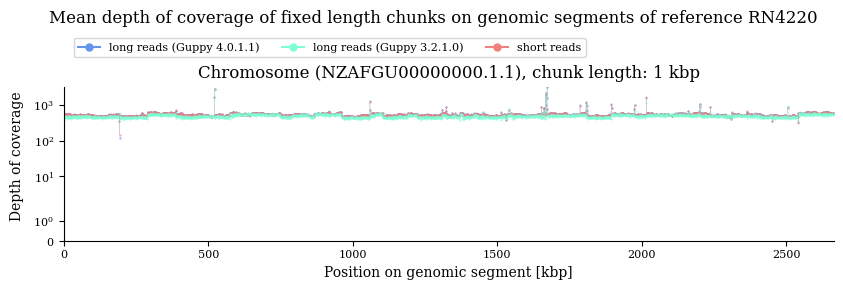

In [18]:
# Prepare the plot, i.e. as the RN4220 reference contains only one chromosome, one subplot is generated.
fig, axs = plt.subplots( nrows = 1, ncols = 1, figsize = set_size( 600, 200 ) )

layoutCoverage( axs, [ RN4220chrCovLongGuppy4011, RN4220chrCovLongGuppy3210, RN4220chrCovShort ], [ 'cornflowerblue', 'lightcoral', 'aquamarine' ], "Position on genomic segment [kbp]", "Chromosome (NZAFGU00000000.1.1), chunk length: 1 kbp" )

# Place labels, legend and titles for the full plot.
fig.text( -0.01, 0.5, 'Depth of coverage', va = 'center', rotation = 'vertical')
fig.suptitle( "Mean depth of coverage of fixed length chunks on genomic segments of reference RN4220", x = 0.5, y = 1.03 )
fig.legend( handles = [ Line2D( [0], [0], marker='o', color='cornflowerblue', label='long reads (Guppy 4.0.1.1)', markerfacecolor='cornflowerblue', markersize=5),
                        Line2D( [0], [0], marker='o', color='aquamarine', label='long reads (Guppy 3.2.1.0)', markerfacecolor='aquamarine', markersize=5),
                        Line2D( [0], [0], marker='o', color='lightcoral', label='short reads', markerfacecolor='lightcoral', markersize=5) ],
            bbox_to_anchor=( 0.69, 0.95 ),
            ncol = 3 )

# Show the plot in tight layout.
plt.tight_layout( )